<a href="https://colab.research.google.com/github/BIRDRED/PUC_DataScience/blob/main/Gustavo_Melo_pratica2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
colab = True 

import os 

if colab:
    !git clone https://github.com/mdrs-thiago/PUC_Redes_Neurais
    os.chdir('/content/PUC_Redes_Neurais/pos_grad/lista 2')

Cloning into 'PUC_Redes_Neurais'...
remote: Enumerating objects: 314, done.
remote: Counting objects: 100% (314/314), done.
remote: Compressing objects: 100% (245/245), done.
remote: Total 314 (delta 121), reused 241 (delta 48), pack-reused 0
Receiving objects: 100% (314/314), 3.98 MiB | 26.31 MiB/s, done.
Resolving deltas: 100% (121/121), done.


# PUC-Rio 
## Departamento de Engenharia Elétrica
## Trabalho 2 - Previsão de séries temporais

Estudante: Gustavo Melo

Base de dados: microclima7

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler, Dataset, DataLoader 
import torch.nn.functional as F

from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

from model_utils import train, train_multi_step_model

from tqdm.notebook import tqdm


## Preparação para a lista

In [3]:
class CustomDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


In [4]:
class NeuralNetwork(torch.nn.Module):
  '''
  Objeto criado para facilitar o desenvolvimento dos scripts das aulas práticas.
  Opção alternativa à criação externa fdo modelo. Basicamente serve como um 
  'agregador'  de trechos comuns para a criação do modelo. Por exemplo, ao invés
  de gastar n+1 linhas para a criação de um modelo com n camadas, podemos criar 
  o mesmo modelo com apenas uma linha.
  
  Parâmetros de entrada: 
  - hidden_neurons: Lista com a quantidade de neurônios na camada escondida. 
  - hidden_activation: Função de ativação para cada camada escondida. Aceita 
  como parâmetro string ou lista. Caso o parâmetro receba string, então a mesma
  função de ativação é utilizada para todas as camadas escondidas. Caso seja uma 
  lista, cada camada terá sua propria função de ativação definida pela lista.
  - output_activation: Função de ativação para a camada de saída.
  - lr: Taxa de aprendizado
  - n_input: Tamanho do vetor de entrada.
  - n_output: Saída do modelo.
  '''
  def __init__(self,hidden_neurons = 4, hidden_activation = 'relu', output_activation='softmax', lr = 0.05, n_input = 1, n_output = 1):
    # create model
    super(NeuralNetwork, self).__init__()

    self.activations = {'relu': nn.ReLU(), 'sigmoid':nn.Sigmoid(), 'softmax':nn.Softmax()}

    self.fc1 = nn.Linear(n_input, hidden_neurons)
    self.ha = self.activations[hidden_activation]
    self.fc2 = nn.Linear(hidden_neurons, n_output)
    #self.out = self.activations[output_activation]
    
    #self.out = nn.Sigmoid() #Para o caso binário
  def forward(self,x):
    h = self.fc1(x)
    h1 = self.ha(h) 
    y = self.fc2(h1) 
    #y = self.out(h2)
    return y


In [5]:
def transform_data(data, lag = 1, test_split = 0.1, normalize = True, category = 'binary'):
    
    '''
    Função para transformação de dados para a 2ª Lista de exercícios.
    A transformação de dados nesta etapa tem duas funções principais: a transformação da série em uma forma tabular para 
    o aprendizado de Redes Neurais e normalização dos dados.
    Parâmetros de entrada:
    - data: base de dados a ser ajeitado.
    - test_split: propoporção da base de dados para teste. Caso seja um float entre 0 e 1, o valor é interpretado como proporção. 
    Caso seja um valor inteiro, é compreendido como o tempo reservado para generalização (e.g. lag = 12 reserva os 12 últimos 
    registros para o teste).
    - normalize: normalização da série. Default True
    - categ: string contendo a codificação a ser realizada para a variável exógena (no caso, o mês).

    A função retorna dois dataframes, sendo o primeiro para treinamento e o segundo para generalização.
    '''

    global _min
    global _max
    
    
    data_values = data.values
    
    if 0 < test_split < 1.0:
        l = data_values.shape[0]
        train_values = data_values[:-int(test_split*l),0].reshape(-1,1)
        test_values = data_values[-int(test_split*l):,0].reshape(-1,1)
        train_idx = data_values[:-int(test_split*l),1].reshape(-1,1)
        test_idx = data_values[-int(test_split*l):,1].reshape(-1,1)
        
    elif test_split > 1 and type(test_split) is int:

        train_values = data_values[:-test_split,0].reshape(-1,1)
        test_values = data_values[-test_split:,0].reshape(-1,1)
        train_idx = data_values[:-test_split,1].reshape(-1,1)
        test_idx = data_values[-test_split:,1].reshape(-1,1)
        
    else:
        print('Test split not understood. Test split should be float between 0 and 1 or integer for index')
    
    assert test_values.shape[0] >= (lag)
    
    _min = np.min(train_values)
    _max = np.max(train_values)
    
    if normalize:
        
        test_values = (test_values - _min)/(_max - _min)
        train_values = (train_values - _min)/(_max - _min)
        
    train_data = np.zeros((train_values.shape[0] - (lag + 1), lag + 2))
    test_data = np.zeros((test_values.shape[0], lag + 2))
    
    
    all_data = np.vstack((train_values,test_values))
    all_idx = np.vstack((train_idx,test_idx))

    new_data = np.zeros((train_values.shape[0] - (lag + 1) + test_values.shape[0],lag + 2))
    
    
    
    for i in range(lag + 2):
        new_data[:,i] = all_data[i:new_data.shape[0]+i,0]
        

    
    if category == 'binary':
        binary_rep = [np.binary_repr(z,width=4) for z in all_idx.astype('int').reshape(-1,)]
        t0 = np.array([int(v) for s in binary_rep for v in s[0]])
        t1 = np.array([int(v) for s in binary_rep for v in s[1]])
        t2 = np.array([int(v) for s in binary_rep for v in s[2]])
        t3 = np.array([int(v) for s in binary_rep for v in s[3]])
        t = np.vstack((t0,t1,t2,t3)).T
        t = t[-new_data.shape[0]:,:]
        temp_idx = [f'month_{i}' for i in range(4)]
        
    elif category == '1toN':
        pass
    
    else:
        t = (all_idx - np.min(train_idx))/(np.max(train_idx) - np.min(train_idx))
        t = t.reshape(-1,1)
        t = t[-new_data.shape[0]:,:]
        temp_idx = ['month']
    
    
    new_data = np.hstack((t,new_data))
    
    train_data = new_data[:-test_values.shape[0],:]
    test_data = new_data[-test_values.shape[0]:,:]
    
    
    data_columns = [f'y(t{i})' if i < 0 else 'y(t)' if i == 0 else f'y(t+{i})' for i in range(-lag,2)] 
    temp_idx.extend(data_columns)
    new_train_df = pd.DataFrame(train_data, columns=temp_idx)
    new_test_df = pd.DataFrame(test_data, columns=temp_idx)
    
    
    
    
    return new_train_df, new_test_df
        
    
    
    

In [6]:
dataset_name = 'microclima7'
path = f'https://raw.githubusercontent.com/mdrs-thiago/PUC_Redes_Neurais/main/datasets/s_{dataset_name}.csv'
raw_data = pd.read_csv(path)

## Parte I - Compreensão do problema

Total: 3,0 pts.

#### 1.	Visualize, em forma de gráfico, a dinâmica temporal da série escolhida. A série é adequada para a modelagem usando Redes Neurais? Caso não seja, que técnicas podem ser aplicadas para ajustar o comportamento da série?

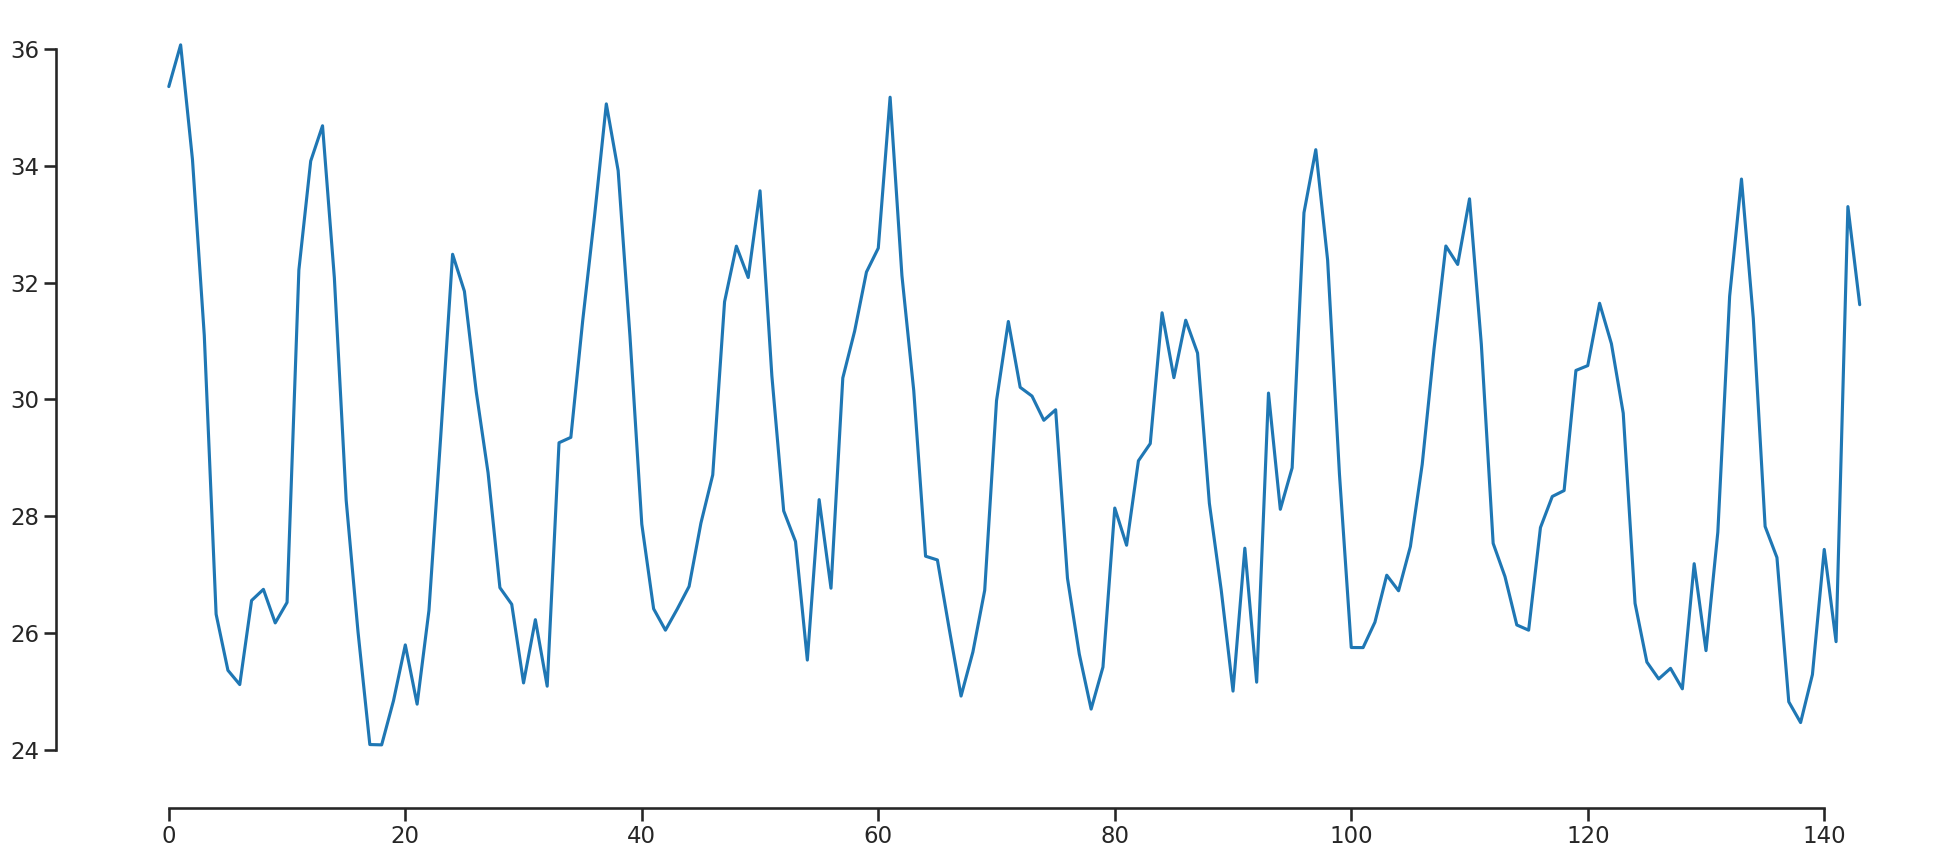

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
sns.set_style("ticks")

fig, ax = plt.subplots(1, 1, figsize=(24, 10))
raw_data['value'].plot(ax=ax)
sns.despine(offset=20, trim=True)

<Axes: >

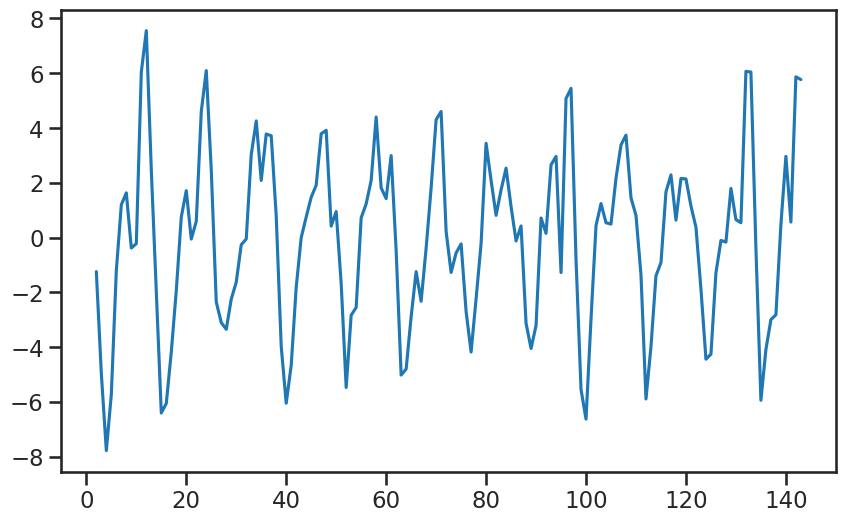

In [8]:
raw_data.value.diff(2).plot(figsize=(10, 6))

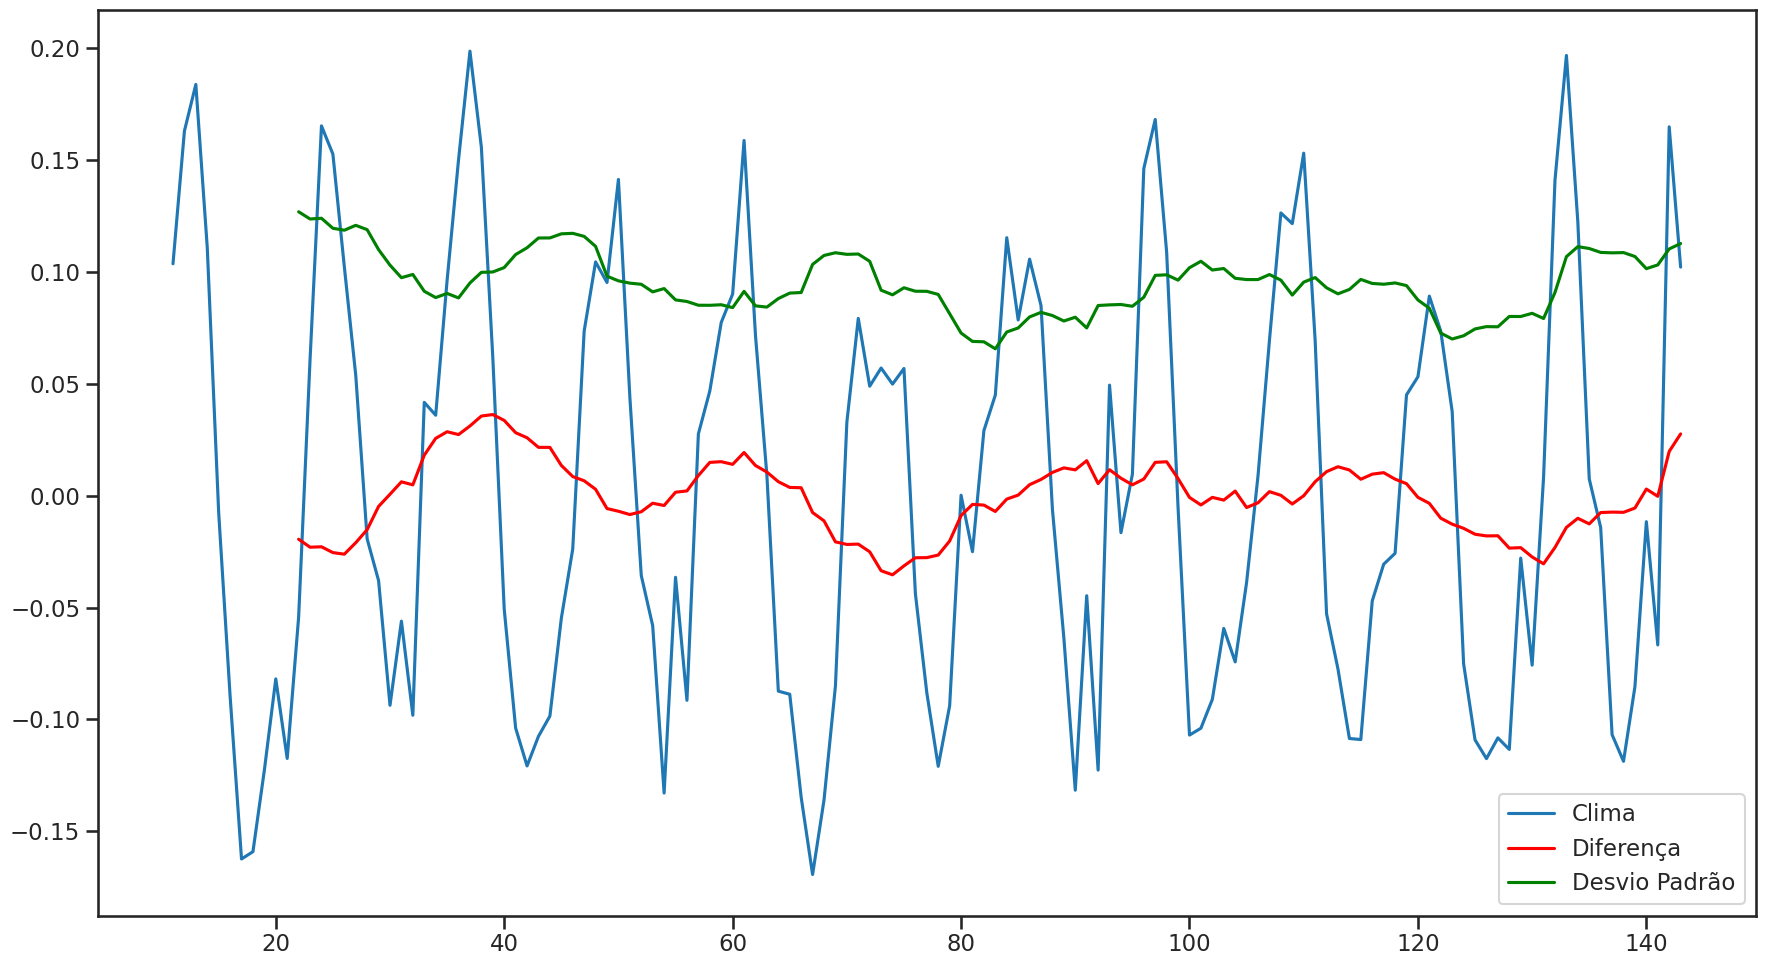

In [9]:
df_log = np.log(raw_data['value'])
ma_log = df_log.rolling(12).mean()

#subtrair média do log dos dados, iremos fazer a média em 12, pois iremos fazer anualmente
df_sub = (df_log - ma_log).dropna()
ma_sub = df_sub.rolling(12).mean()
#desvio padrão
std_sub = df_sub.rolling(12).std()

fig, ax = plt.subplots(1, 1, figsize=(18, 10))
df_sub.plot(ax=ax, legend=True,label='Clima')
ma_sub.plot(ax=ax, legend=True, color='r',label='Diferença')
std_sub.plot(ax=ax, legend=True, color='g',label='Desvio Padrão')
plt.tight_layout()

A série se tornou adequada para a resolução do modelo de serie temporal pois há um padrão para os dados obtidos

#### 2.	Nesta 2ª lista de exercícios, usaremos uma variável exógena que representa o mês de previsão (i.e. no instante t+1). De que forma esta variável pode auxiliar na previsão da série temporal?

A variável exogena auxilia na criação da previsão temporal pois conseguimos observar a tendencia dos dados do clima especificado para gerar o comportamento de acordo com o periodo de tempo especificado que pode melhorar a precisão das previsões do tempo.

O objetivo da utilização das variaveis exógenas pode gerenciar o que afeta a série temporal levando em consideração as datas que vão além do que é feito pelos dados,  é possível ver se há nessa série temporal uma sazonalidade nos periodos definidos e se há uma manutenção desses dados e dessas tendencias de acordo com o que o modelo for treinado.



#### 3. Observe que a base de dados não está em um formato adequado para o uso imediato de um modelo de Rede Neural para previsão de séries temporais. Descreva as etapas necessárias de transformação desta base de dados para que possamos utilizá-la no treinamento de uma MLP. Considere que os padrões de entrada (e saída) devem ser normalizados.

Os passos feitos a seguir para se construir a transformação de MLP que estão sendo feitos na função transform_data, segue nos passos a seguir:

1.   Divisão dos dados - Divide os dados em treinamento e testes
2.   Normalização dos dados - Transforma os dados em mini maximo atraves do clima gerado 
3.   Transformação das sequencias - Transforma os dados gerando uma sequencia com um número de dados que vai gerar um saida , no caso iremos utilizar os dados com 12 sequencias 


## Parte 2 - Previsão one-step

Total: 2,0 pts

<b> IMPORTANTE! </b> Este processo não é a previsão multi-step, conforme ensinado em sala de aula. 
Esta parte da lista é importante para evitar erros de avaliação para a previsão de séries temporais com um horizonte de previsão maior que 1.

#### 1.	Execute o script para a previsão one-step. Avalie o resultado (conjunto de treinamento e teste) usando métricas apropriadas, como RMSE e MAE.

In [10]:
prev = 12
train_val ,test_val = transform_data(raw_data,lag=12,test_split = prev,normalize=True,category='binary')

In [11]:
train_values = train_val.values

X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

In [12]:
train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))

test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

In [13]:
batch_size = 32

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)

test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [14]:
n_input = X_train.shape[1]
n_output = 1
hidden_neurons = 20

In [15]:
model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lr = 0.05
epochs = 1000

history, y_hat = train(model, train_loader, epochs, device, lr)

  6%|▌         | 62/1000 [00:00<00:09, 102.23it/s]

Epoch 51/1000, Loss: 0.0311


 11%|█         | 106/1000 [00:01<00:16, 54.41it/s]

Epoch 101/1000, Loss: 0.0184


 17%|█▋        | 172/1000 [00:02<00:08, 97.67it/s]

Epoch 151/1000, Loss: 0.0127


 22%|██▏       | 215/1000 [00:02<00:07, 111.24it/s]

Epoch 201/1000, Loss: 0.0114


 27%|██▋       | 271/1000 [00:03<00:05, 125.10it/s]

Epoch 251/1000, Loss: 0.0111


 32%|███▏      | 319/1000 [00:03<00:04, 144.71it/s]

Epoch 301/1000, Loss: 0.0109


 36%|███▋      | 364/1000 [00:03<00:05, 113.69it/s]

Epoch 351/1000, Loss: 0.0107


 42%|████▏     | 420/1000 [00:04<00:04, 119.99it/s]

Epoch 401/1000, Loss: 0.0106


 48%|████▊     | 480/1000 [00:04<00:03, 132.59it/s]

Epoch 451/1000, Loss: 0.0104


 53%|█████▎    | 526/1000 [00:05<00:03, 136.55it/s]

Epoch 501/1000, Loss: 0.0103


 57%|█████▋    | 567/1000 [00:05<00:03, 108.37it/s]

Epoch 551/1000, Loss: 0.0101


 62%|██████▏   | 616/1000 [00:05<00:02, 129.51it/s]

Epoch 601/1000, Loss: 0.0100


 67%|██████▋   | 673/1000 [00:06<00:02, 129.64it/s]

Epoch 651/1000, Loss: 0.0099


 72%|███████▏  | 724/1000 [00:06<00:01, 149.41it/s]

Epoch 701/1000, Loss: 0.0098


 78%|███████▊  | 775/1000 [00:07<00:01, 159.99it/s]

Epoch 751/1000, Loss: 0.0097


 83%|████████▎ | 826/1000 [00:07<00:01, 154.71it/s]

Epoch 801/1000, Loss: 0.0096


 87%|████████▋ | 873/1000 [00:07<00:00, 132.43it/s]

Epoch 851/1000, Loss: 0.0095


 91%|█████████ | 910/1000 [00:08<00:01, 79.00it/s]

Epoch 901/1000, Loss: 0.0094


 95%|█████████▌| 953/1000 [00:09<00:00, 54.03it/s]

Epoch 951/1000, Loss: 0.0094


100%|██████████| 1000/1000 [00:10<00:00, 97.97it/s]

Epoch 1001/1000, Loss: 0.0093


In [16]:
y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

In [17]:
from sklearn.metrics import r2_score

Erro MSE = 4.505 
Erro MAE = 1.548
R2 Score = 0.581


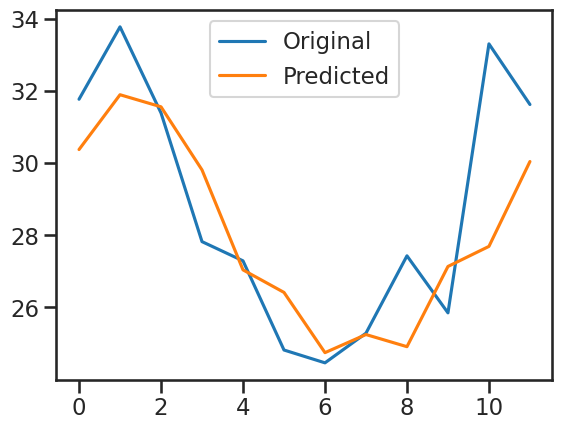

In [18]:
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_hat*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)
r2_error = r2_score(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')
print(f'R2 Score = {round(r2_error,3)}')


De acordo com o modelo utilizado e as métricas colocadas a disposição temos que cerca de 59% dos valores estão corretos de acordo com o R2 Score e de acordo com as métrica MAE os valores que estão 1,5ºC tanto para mais ou para menos.
Como a diferença entre MAE e MSE não é tão grande podemos avaliar que não há um grande numero de registro de outliers que componham os dados pois o MSE acaba ampliando os valores descritos nos valores discrepantes

#### 2.	Modifique a técnica de codificação mensal de ‘binário’ para ‘numérico’. Qual a mudança existente na arquitetura da Rede Neural? Analise o resultado (conjunto de treinamento e teste), usando as métricas adequadas.

In [19]:
train_val_real ,test_val_real = transform_data(raw_data,lag=12,test_split = prev,normalize=True,category='real')

In [20]:
train_values = train_val_real.values

X_train_real = train_values[:,:-1]
y_train_real = train_values[:,-1]

test_values = test_val_real.values
X_test_real = test_values[:,:-1]
y_test_real = test_values[:,-1]

In [21]:
train_dataset = CustomDataset(torch.from_numpy(X_train_real).float(), torch.from_numpy(y_train_real).float().unsqueeze(1))

test_dataset = CustomDataset(torch.from_numpy(X_test_real).float(), torch.from_numpy(y_test_real).float().unsqueeze(1))

In [22]:
n_input = X_train_real.shape[1]
n_output = 1
hidden_neurons = 20

In [24]:
batch_size = 32

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [229]:
model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lr = 0.05
epochs = 1000

history, y_hat = train(model, train_loader, epochs, device, lr)

  8%|▊         | 78/1000 [00:00<00:05, 183.32it/s]

Epoch 51/1000, Loss: 0.0326


 14%|█▎        | 135/1000 [00:00<00:04, 184.19it/s]

Epoch 101/1000, Loss: 0.0206


 19%|█▉        | 191/1000 [00:00<00:03, 234.53it/s]

Epoch 151/1000, Loss: 0.0144
Epoch 201/1000, Loss: 0.0126


 31%|███       | 306/1000 [00:01<00:02, 270.84it/s]

Epoch 251/1000, Loss: 0.0121
Epoch 301/1000, Loss: 0.0119


 39%|███▉      | 391/1000 [00:01<00:02, 270.24it/s]

Epoch 351/1000, Loss: 0.0118
Epoch 401/1000, Loss: 0.0116


 48%|████▊     | 480/1000 [00:01<00:01, 280.76it/s]

Epoch 451/1000, Loss: 0.0115
Epoch 501/1000, Loss: 0.0114


 60%|█████▉    | 595/1000 [00:02<00:01, 277.23it/s]

Epoch 551/1000, Loss: 0.0113
Epoch 601/1000, Loss: 0.0111


 68%|██████▊   | 680/1000 [00:02<00:01, 265.83it/s]

Epoch 651/1000, Loss: 0.0110
Epoch 701/1000, Loss: 0.0109


 76%|███████▋  | 765/1000 [00:03<00:00, 275.11it/s]

Epoch 751/1000, Loss: 0.0108


 82%|████████▏ | 818/1000 [00:03<00:00, 210.34it/s]

Epoch 801/1000, Loss: 0.0107


 86%|████████▌ | 861/1000 [00:03<00:00, 169.92it/s]

Epoch 851/1000, Loss: 0.0106


 95%|█████████▌| 954/1000 [00:04<00:00, 215.99it/s]

Epoch 901/1000, Loss: 0.0105
Epoch 951/1000, Loss: 0.0104


100%|██████████| 1000/1000 [00:04<00:00, 233.63it/s]

Epoch 1001/1000, Loss: 0.0104


In [26]:
y_pred = model(torch.from_numpy(X_test_real).float())

In [27]:
y_hat = y_pred.detach().numpy()

In [28]:
from sklearn.metrics import r2_score

Erro MSE = 4.365 
Erro MAE = 1.535
R2 Score = 0.594


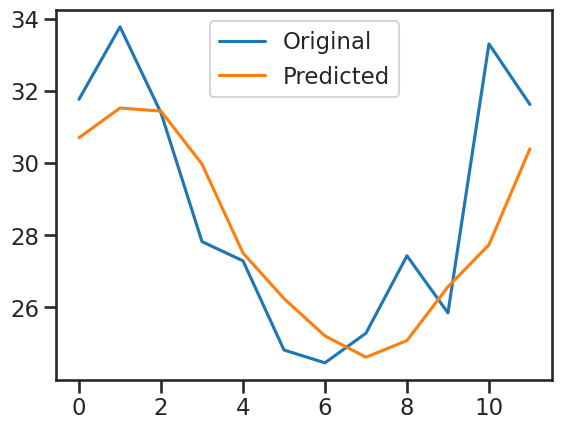

In [29]:
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_hat*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)
r2_error = r2_score(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')
print(f'R2 Score = {round(r2_error,3)}')

De acordo com o modelo utilizado e as métricas colocadas a disposição temos que cerca de 58,4% dos valores estão corretos de acordo com o R2 Score e de acordo com as métrica MAE os valores que estão 1,55ºC tanto para mais ou para menos.
Como a diferença entre MAE e MSE não é tão grande podemos avaliar que não há um grande numero de registro de outliers que componham os dados pois o MSE acaba ampliando os valores descritos nos valores discrepantes

## Parte 3 - Previsão multi-step

Total: 5,0 pts.

#### 1.	Esquematize como você implementaria o processo de previsão multi-step. Descreva todos os passos necessários, e em seguida compare com o código fornecido para a previsão. 

In [30]:
def multi_step(model, X_test, cod='numeric'):
  y_result = []
  X_t = np.copy(X_test[0])

  for i in range(prev):
      y_hat = model(torch.from_numpy(X_t).float())
      
      if cod == 'numeric':

        #Ajeitando a codificação. Transformamos para o valor do mês e somamos 1 (para o próximo passo) e 
        #depois pegamos o resto da divisão por 12 (para que o mês fique sempre entre 0 e 11)
        tmp = int(X_t[0] * 12 + 1) % 12
        
        #Alterando a variável mês
        X_t[0] = tmp/12
        
        #Movendo todos os registros, 'deslizando a janela'
        X_t[1:X_t.shape[0]-1] = X_t[2:]

      elif cod == 'binary':
        pass

      else:
        print('Erro de codificação.')
        break
      

      X_t[-1] = y_hat
      
      y_result.append(y_hat[0].detach().numpy())

  return np.array(y_result)

Os passos necessários para a utilização do modelo multi-step são:

1.   Em um primeiro passo eu iria determinar e colocar na função o valor de quantos passos iria ser a prévia do multi-step
2.   Em seguida iria ajustar o modelo para rodar podendo ampliar as opções do modelo caso fosse necessário um teste diferente
3.   Iria adequar a base de teste para que tivesse uma melhoria nos dados que serão utilizados para ter uma base que rodasse no modelo de forma correta
4.  Para finalizar eu iria fazer o treino e a predição dos dados subsequentes

Para o código que foi colocado como multi-step eu iria diferenciar com o modelo colocado e os valores disponibilizados para a codificação de forma com que se tenha essa diferenciação e maior facilidade para utilizar em outros modelos


#### 2.	Faça a previsão multi-step para o horizonte de previsão igual a 12. Perceba que o resultado da métrica é, geralmente, pior do que o apresentado para a previsão one-step. Por quê? É justo comparar o resultado deste item com o que foi apresentado anteriormente? Discuta. 

In [31]:
prev = 12
train_val ,test_val = transform_data(raw_data,lag=12,test_split = prev,normalize=True,category='numeric')

In [32]:
train_values = train_val.values

X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

In [33]:
model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')

In [34]:
train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))

test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

In [35]:
batch_size = 32

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)

test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [36]:
n_input = X_train.shape[1]
n_output = 1
hidden_neurons = 20

In [37]:
y_result = multi_step(model, X_test, cod='numeric')

Erro MSE = 25.631 
Erro MAE = 3.956


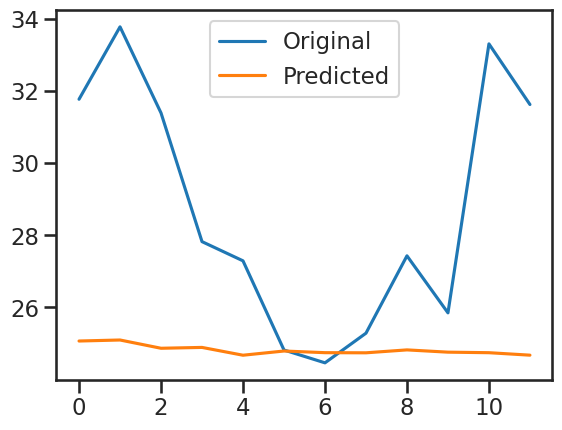

In [38]:
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

O erro é maior quando utilizamos o multi-step por que temos uma maior propagação dos erros que são gerados pelo modelo do que no one step e este erro pode ser aumentado conforme passa o tempo portanto não é justo comparar o multi-step com o one step por que teremos uma incerteza maior do que no one step e isso gera uma maior imprevisiblidade enquanto o modelo é seguido de acordo o tempo.

#### 3.	Modifique o tamanho da janela de entrada do modelo. Analise os resultados, utilizando as métricas adequadas. 

In [172]:
def multi_step_window(model, window,X_test, cod='numeric'):
  y_result = []
  X_t = np.copy(X_test[0])
  for i in range(prev):
      y_hat = model(torch.from_numpy(X_t).float())
      
      if cod == 'numeric':

        #Ajeitando a codificação. Transformamos para o valor do mês e somamos 1 (para o próximo passo) e 
        #depois pegamos o resto da divisão por 12 (para que o mês fique sempre entre 0 e 11)
        tmp = int(X_t[0] * window + 1) % window
        
        #Alterando a variável mês
        X_t[0] = tmp/window
        
        #Movendo todos os registros, 'deslizando a janela'
        X_t[1:X_t.shape[0]-1] = X_t[2:]

      elif cod == 'binary':
        pass

      else:
        print('Erro de codificação.')
        break
      

      X_t[-1] = y_hat
      
      y_result.append(y_hat[0].detach().numpy())


  return np.array(y_result)

In [210]:
  def multistep (janela):
    prev = janela
    train_val ,test_val = transform_data(raw_data,lag=janela,test_split = prev,normalize=True,category='numeric')
    train_values = train_val.values
    X_train = train_values[:,:-1]
    y_train = train_values[:,-1]
    test_values = test_val.values
    X_test = test_values[:,:-1]
    y_test = test_values[:,-1]
    n_input = X_train.shape[1]
    n_output = 1
    hidden_neurons = 20
    model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
    batch_size = 32
    train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
    test_loader = DataLoader(dataset=test_dataset, batch_size=1)
    y_result = multi_step_window(model, janela, X_test, cod='numeric')
    return y_result

In [208]:
janela = [3,6,9,12,15,18,21,24,27,30]
mae_error = []
mse_error = []
orig_y_eval = []
orig_y_hat = []
for x in range(0,len(janela)):
   y_result = multistep(janela[x])
   orig_y_eval = y_test*(_max-_min) + _min
   orig_y_hat = y_result*(_max-_min) + _min
   mae_error.append(mean_absolute_error(orig_y_eval, orig_y_hat))
   mse_error.append(mean_squared_error(orig_y_eval, orig_y_hat))

resultado = dict(janela = janela,
                   mae_error = mae_error,
                   mse_error = mse_error)
resultado_df = pd.DataFrame(data=resultado)

In [209]:
resultado_df

,janela,mae_error,mse_error
0,3,3.772221,23.811812
1,6,7.395756,65.015458
2,9,5.113742,37.827483
3,12,4.845179,33.889363
4,15,2.814428,10.462814
5,18,8.200917,78.252277
6,21,11.756977,149.889047
7,24,7.581878,68.443352
8,27,3.868371,24.661249
9,30,10.175166,114.353570


Pode se avaliar que há um certo crescimento de acordo com o aumento da janela chegando a quanto maior um número de acordo com o aumento da janela fazendo com que haja uma maior propagação de erros

#### 4.	Modifique a topologia da rede para obter um melhor desempenho. Altere seus parâmetros (e.g. número de processadores na camada escondida, tipo de função na camada de saída) e avalie o desempenho.

In [212]:
def multi_step(model, X_test, cod='numeric'):
  y_result = []
  X_t = np.copy(X_test[0])
  for i in range(prev):
      y_hat = model(torch.from_numpy(X_t).float())
      
      if cod == 'numeric':

        #Ajeitando a codificação. Transformamos para o valor do mês e somamos 1 (para o próximo passo) e 
        #depois pegamos o resto da divisão por 12 (para que o mês fique sempre entre 0 e 11)
        tmp = int(X_t[0] * 12 + 1) % 12
        
        #Alterando a variável mês
        X_t[0] = tmp/12
        
        #Movendo todos os registros, 'deslizando a janela'
        X_t[1:X_t.shape[0]-1] = X_t[2:]

      elif cod == 'binary':
        pass

      else:
        print('Erro de codificação.')
        break
      

      X_t[-1] = y_hat
      
      y_result.append(y_hat[0].detach().numpy())


  return np.array(y_result)

In [253]:
  def multistep_lr (lrmetric):
    prev = 12
    train_val ,test_val = transform_data(raw_data,lag=12,test_split = prev,normalize=True,category='numeric')
    train_values = train_val.values
    X_train = train_values[:,:-1]
    y_train = train_values[:,-1]
    test_values = test_val.values
    X_test = test_values[:,:-1]
    y_test = test_values[:,-1]
    n_input = X_train.shape[1]
    n_output = 1
    hidden_neurons = 20
    model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid',lr = lrmetric)
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
    batch_size = 32
    train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
    test_loader = DataLoader(dataset=test_dataset, batch_size=1)
    y_result = multi_step(model, X_test, cod='numeric')
    return y_result

In [263]:
lr = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
mae_error = []
mse_error = []
orig_y_eval = []
orig_y_hat = []
for x in range(0,len(lr)):
   y_result = multistep_lr(lr[x])
   orig_y_eval = y_test*(_max-_min) + _min
   orig_y_hat = y_result*(_max-_min) + _min
   mae_error.append(mean_absolute_error(orig_y_eval, orig_y_hat))
   mse_error.append(mean_squared_error(orig_y_eval, orig_y_hat))

resultado = dict(lr = lr,
                   mae_error = mae_error,
                   mse_error = mse_error)
resultado_df = pd.DataFrame(data=resultado)

In [264]:
resultado_df

,lr,mae_error,mse_error
0,0.05,3.255048,17.490391
1,0.10,3.576547,21.700645
2,0.20,3.805917,21.648398
3,0.30,7.951305,74.328491
4,0.40,2.937483,10.170454
5,0.50,2.959265,12.381379
6,0.60,5.937216,45.908152
7,0.70,5.890486,45.175988
8,0.80,11.600582,145.011434
9,0.90,4.215028,28.414965


Em uma determinada faixa de valor da taxa de aprendizado temos um aumento do erro e em seguida uma normalização dos erros e quanto menor o lr (taxa de aprendizado) menor tende ser a taxa de erro 

#### 5. Modifique a função de previsão multi-step para permitir a codificação binária da variável mês. Em seguida, treine um modelo MLP usando a codificação binária para a variável exógena e faça a previsão multi-step e analise o resultado. 

OBS: Para este item, basta alterar a atualização da variável exógena na condição desejada (no caso, cod = 'binary')

In [294]:
def multi_step(model, X_test, cod='binary'):
  y_result = []
  X_t = np.copy(X_test[0])

  for i in range(prev):
      y_hat = model(torch.from_numpy(X_t).float())
      
      if cod == 'numeric':

        #Ajeitando a codificação. Transformamos para o valor do mês e somamos 1 (para o próximo passo) e 
        #depois pegamos o resto da divisão por 12 (para que o mês fique sempre entre 0 e 11)
        tmp = int(X_t[0] * 12 + 1) % 12
        
        #Alterando a variável mês
        X_t[0] = tmp/12
        
        #Movendo todos os registros, 'deslizando a janela'
        X_t[1:X_t.shape[0]-1] = X_t[2:]

      elif cod == 'binary':
        #Ajeitando a codificação. Transformamos para o valor do mês e somamos 1 (para o próximo passo) e 
        #depois pegamos o resto da divisão por 12 (para que o mês fique sempre entre 0 e 11)
        tmp = int(X_t[4] * 12 + 1) % 12
        
        #Alterando a variável mês
        X_t[4] = tmp/12
        
        #Movendo todos os registros, 'deslizando a janela'
        X_t[1:X_t.shape[0]-1] = X_t[2:]

      else:
        print('Erro de codificação.')
        break
      

      X_t[-1] = y_hat
      
      y_result.append(y_hat[0].detach().numpy())

  return np.array(y_result)

In [295]:
prev = 12
train_val ,test_val = transform_data(raw_data,lag=12,test_split = prev,normalize=True,category='binary')

In [296]:
train_values = train_val.values
X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values
X_test = test_values[:,:-1]
y_test = test_values[:,-1]

In [297]:
model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')

In [298]:
train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

In [299]:
batch_size = 32
train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [300]:
n_input = X_train.shape[1]
n_output = 1
hidden_neurons = 20

In [301]:
batch_size = 32
train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [302]:
y_result = multi_step(model, X_test, cod='binary')

Erro MSE = 13.322 
Erro MAE = 2.938


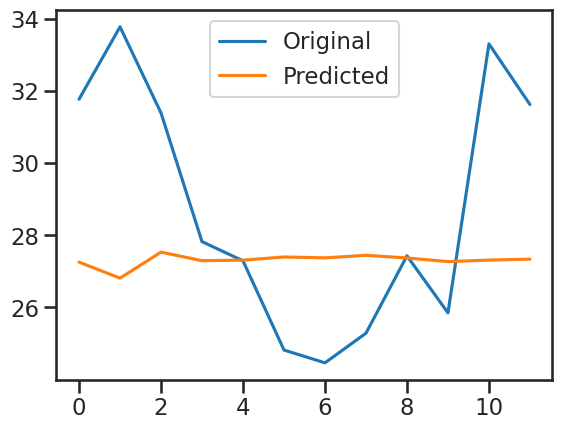

In [303]:
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

O resultado da binária foi melhor que os dados obtidos na categoria numérica pois tende a ser dividido e com isso diminuindo o erro dos valores obtidos através do modelo fdazendo com que haja melhor diminuindo da média através do MAE fazendo com que haja uma equalização com os valores do clima destinado 